# Initialization

In [1]:
import os
import re
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

### set experiment dates

In [2]:
year = 2005 

### set directories

In [3]:
dir_root = os.path.join('..')
dir_data_processing = os.path.join(dir_root, 'data_processing')
dir_reports_ready =  os.path.join(dir_data_processing, 'reports_ready')
dir_plots = os.path.join(dir_root, 'plots')

### set flags

In [4]:
flag_debug = False

# Read data reports from files

In [5]:
def read_report(dir_name, file_name):
    file_path = os.path.join(dir_name, file_name)
    result = []
    with open(file_path, 'r') as f_r:
        for text_line in f_r:
            result = result + text_line.strip().split(' ')
    return result        

In [6]:
reports_list = []

regExp = re.compile('[A-Z\d]+\_[A-Z\d]+\-' + str(year) + '\_[\d]+\.txt$')
reports_of_year = [f for f in os.listdir(dir_reports_ready) if re.search(regExp, f)]
reports_of_year.sort()
# for every reports of the year
for report_name in reports_of_year:
    reports_list.append(read_report(dir_reports_ready, report_name))

print('Done on %s, number of documents: %s' % (year, len(reports_of_year)))

Done on 2005, number of documents: 233


# Corpus construction

In [7]:
import gensim
import gensim.corpora as corpora

## Create Dictionary

In [8]:
id2word = corpora.Dictionary(reports_list)

## Create Corpus

In [9]:
corpus = [id2word.doc2bow(text) for text in reports_list]

In [10]:
print('Number of unique tokens: %s' %len(id2word))

Number of unique tokens: 13741


view the first document as BOW

In [11]:
if flag_debug:
    print(corpus[:1])

# Find optimal topic number

In [12]:
from gensim.models import CoherenceModel

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3, passes=10, random_state=100):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    perplexity_values = []
    model_list = []
    i = 0
    for num_topics in range(start, limit + 1, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=random_state,
                                           update_every=5,
                                           chunksize=100,
                                           passes=passes,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v_score = coherencemodel.get_coherence()
        coherence_values.append(c_v_score)
        
        perplexity = model.log_perplexity(corpus)
        perplexity_values.append(perplexity)
        
        print('Done on indx: %s T: %s, c_v score: %s, perplexity: %s' % (i, num_topics, c_v_score, perplexity))
        i += 1
    return model_list, coherence_values, perplexity_values

In [14]:
min_T = 5
max_T = 60
step_T = 1
passes_T = 51
random_state = 193748

In [15]:
model_list, coherence_values, perplexity_values = compute_coherence_values(
    dictionary=id2word, 
    corpus=corpus, 
    texts=reports_list, 
    start=min_T, 
    limit=max_T, 
    step=step_T,
    passes=passes_T,
    random_state=random_state)

Done on indx: 0 T: 5, c_v score: 0.3502959258161873, perplexity: -7.969243664671843
Done on indx: 1 T: 6, c_v score: 0.37389567247849875, perplexity: -7.930224168004542
Done on indx: 2 T: 7, c_v score: 0.3844244704004633, perplexity: -7.8990629110327255
Done on indx: 3 T: 8, c_v score: 0.4446338572271833, perplexity: -7.871458827751808
Done on indx: 4 T: 9, c_v score: 0.4456345569433144, perplexity: -7.845053711257105
Done on indx: 5 T: 10, c_v score: 0.4073397082966566, perplexity: -7.817540241357916
Done on indx: 6 T: 11, c_v score: 0.41023211074079435, perplexity: -7.796680147821365
Done on indx: 7 T: 12, c_v score: 0.4999893972130831, perplexity: -7.762755562512124
Done on indx: 8 T: 13, c_v score: 0.464786435314172, perplexity: -7.754426633822013
Done on indx: 9 T: 14, c_v score: 0.486313739660067, perplexity: -7.732003037963225
Done on indx: 10 T: 15, c_v score: 0.48333251153249523, perplexity: -7.715192783204141
Done on indx: 11 T: 16, c_v score: 0.47467172096815774, perplexity:

In [16]:
import math
for i in range(len(coherence_values)):
    if math.isnan(coherence_values[i]):
        coherence_values[i] = 0

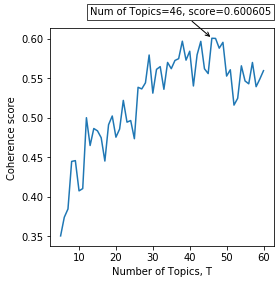

In [17]:
plt.figure(figsize=(4,4))

        
y = np.array(coherence_values)
x = np.array(range(min_T, max_T + 1, step_T))

plt.plot(x, y)    
    
    
xmax = x[np.argmax(y)]
ymax = y.max()
text = 'Num of Topics=%s, score=%f' % (xmax, ymax)

bbox_props = dict(boxstyle='square,pad=0.3', fc='w', ec='k', lw=0.72)
arrowprops=dict(arrowstyle='->')
kw = dict(xycoords='data',textcoords='axes fraction',
          arrowprops=arrowprops, bbox=bbox_props, ha='right', va='top')
plt.annotate(text, xy=(xmax, ymax), xytext=(0.99,1.1), **kw)


plt.xlabel('Number of Topics, T')
plt.ylabel('Coherence score')

#pp = PdfPages(os.path.join(dir_topics, 'cohearence_score.pdf'))

#plt.savefig(pp, format='pdf', bbox_inches='tight')
plt.show()

#pp.close() 
plt.close()

<Figure size 360x360 with 0 Axes>

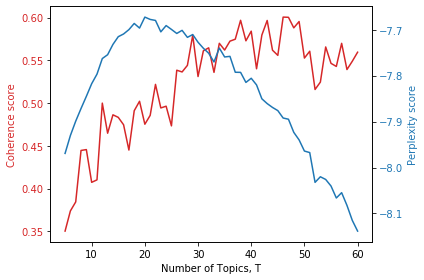

In [18]:
plt.figure(figsize=(5,5))

      
data1 = np.array(coherence_values)
data2 = np.array(perplexity_values)
x = np.array(range(min_T, min_T + len(data1), step_T))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Topics, T')
ax1.set_ylabel('Coherence score', color=color)
ax1.plot(x, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

xmax = x[np.argmax(data1)]
ymax = data1.max()
text = 'Num of Topics=%s, score=%f' % (xmax, ymax)

#bbox_props = dict(boxstyle='square,pad=0.3', fc='w', ec='k', lw=0.72)
#arrowprops = dict(arrowstyle='->')
#kw = dict(xycoords='data',textcoords='axes fraction',
          #arrowprops=arrowprops, bbox=bbox_props, ha='right', va='top')
#ax1.annotate(text, xy=(xmax, ymax), xytext=(0.99,1.1), **kw)

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Perplexity score', color=color)
ax2.plot(x, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() # otherwise the right y-label is slightly clipped

pp = PdfPages(os.path.join(dir_plots, 'cohearence_score.pdf'))

plt.savefig(pp, format='pdf', bbox_inches='tight')
plt.show()

pp.close() 

In [19]:
all_columns = len(coherence_values)
columns = 10
rows = math.ceil(all_columns / columns)

In [20]:
print('\\begin{tabular}{l|%s}' % '|'.join(['c'] * columns))

for r in range(rows):
    start = r * columns
    end = (r + 1) * columns
    
    print('\\hline')
    print('\\textbf{T} & %s \\\\ ' % ' & '.join(['%s' % (x + 5) for x in range(start, end)]))
    print('\\hline')
    print('\\textbf{Coherence score}  & %s \\\\ ' % ' & '.join(['%.4f' % x for x in coherence_values[start:end]]))
    print('\\textbf{Perplexity score} & %s \\\\ ' % ' & '.join(['%.4f' % x for x in perplexity_values[start:end]]))


\begin{tabular}{l|c|c|c|c|c|c|c|c|c|c}
\hline
\textbf{T} & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 & 13 & 14 \\ 
\hline
\textbf{Coherence score}  & 0.3503 & 0.3739 & 0.3844 & 0.4446 & 0.4456 & 0.4073 & 0.4102 & 0.5000 & 0.4648 & 0.4863 \\ 
\textbf{Perplexity score} & -7.9692 & -7.9302 & -7.8991 & -7.8715 & -7.8451 & -7.8175 & -7.7967 & -7.7628 & -7.7544 & -7.7320 \\ 
\hline
\textbf{T} & 15 & 16 & 17 & 18 & 19 & 20 & 21 & 22 & 23 & 24 \\ 
\hline
\textbf{Coherence score}  & 0.4833 & 0.4747 & 0.4451 & 0.4911 & 0.5022 & 0.4753 & 0.4857 & 0.5219 & 0.4944 & 0.4964 \\ 
\textbf{Perplexity score} & -7.7152 & -7.7093 & -7.6998 & -7.6864 & -7.6964 & -7.6726 & -7.6776 & -7.6798 & -7.7047 & -7.6910 \\ 
\hline
\textbf{T} & 25 & 26 & 27 & 28 & 29 & 30 & 31 & 32 & 33 & 34 \\ 
\hline
\textbf{Coherence score}  & 0.4734 & 0.5385 & 0.5364 & 0.5441 & 0.5794 & 0.5311 & 0.5612 & 0.5647 & 0.5360 & 0.5700 \\ 
\textbf{Perplexity score} & -7.6994 & -7.7081 & -7.7014 & -7.7166 & -7.7105 & -7.7273 & -7.7403 & -7.7512 & -

In [21]:
take_first_t_index = 20
coherence_values_in_use = coherence_values[:take_first_t_index]
perplexity_values_in_use = perplexity_values[:take_first_t_index]

<Figure size 360x360 with 0 Axes>

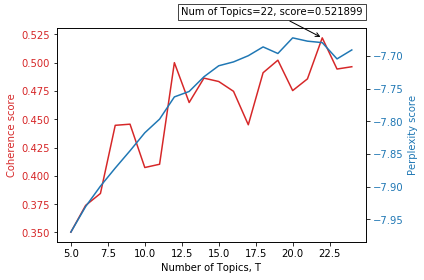

In [22]:
plt.figure(figsize=(5,5))

      
data1 = np.array(coherence_values_in_use)
data2 = np.array(perplexity_values_in_use)
x = np.array(range(min_T, min_T + len(data1), step_T))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Topics, T')
ax1.set_ylabel('Coherence score', color=color)
ax1.plot(x, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

xmax = x[np.argmax(data1)]
ymax = data1.max()
text = 'Num of Topics=%s, score=%f' % (xmax, ymax)

bbox_props = dict(boxstyle='square,pad=0.3', fc='w', ec='k', lw=0.72)
arrowprops = dict(arrowstyle='->')
kw = dict(xycoords='data',textcoords='axes fraction',
          arrowprops=arrowprops, bbox=bbox_props, ha='right', va='top')
ax1.annotate(text, xy=(xmax, ymax), xytext=(0.99,1.1), **kw)

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Perplexity score', color=color)
ax2.plot(x, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() # otherwise the right y-label is slightly clipped
pp = PdfPages(os.path.join(dir_plots, 'cohearence_score_zoom.pdf'))

plt.savefig(pp, format='pdf', bbox_inches='tight')
plt.show()

pp.close() 

In [23]:
best_model_index = np.argmax(np.array(data1))
ts = np.array(range(min_T, min_T + len(data1) + 1, step_T))


best_topics_number = ts[best_model_index]
best_model = model_list[best_model_index]

In [24]:
print('Best T: %s' % best_topics_number)

Best T: 22


In [25]:
for i in range(best_topics_number):
    print([id2word.id2token[x[0]] for x in best_model.get_topic_terms(i, topn=5)])

['mobile', 'wireless', 'voice', 'license', 'subscriber']
['coca_cola', 'premier', 'gallon', 'hotel', 'travel']
['steel', 'client', 'automotive', 'elevator', 'forth']
['reinsurance', 'casualty', 'hotel', 'policyholder', 'insurer']
['thousand', 'marketable', 'automotive', 'unrealized', 'convertible']
['convertible', 'crude_oil', 'client', 'consulting', 'barrel']
['lens', 'optical', 'thousand', 'laboratory', 'vision']
['patent', 'pharmaceutical', 'drug', 'patient', 'expiration']
['aircraft', 'defence', 'space', 'military', 'air']
['mail', 'noncurrent', 'stockholder', 'logistic', 'subgroup']
['mortgage', 'undertaking', 'card', 'preference', 'client']
['millions', 'valeur', 'titre', 'montant', 'ally']
['client', 'memory', 'headline', 'advertising', 'taxation']
['registration', 'client', 'shelf', 'affiliate', 'extraordinary']
['mine', 'gold', 'ore', 'mining', 'copper']
['passenger', 'aircraft', 'car', 'fleet', 'traffic']
['chase', 'card', 'heritage', 'mortgage', 'client']
['reinsurance', 'ca

# EnD